# Method 6 - Rest Ideas After 1

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 1].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

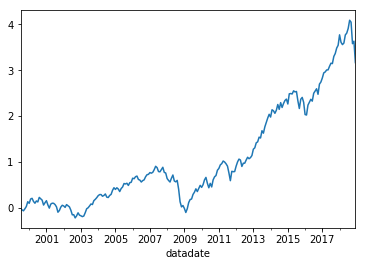

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.132296
2000-12-31   -0.020193
2001-12-31   -0.049786
2002-12-31   -0.204246
2003-12-31    0.454022
2004-12-31    0.178267
2005-12-31    0.082672
2006-12-31    0.111139
2007-12-31    0.017232
2008-12-31   -0.403603
2009-12-31    0.419734
2010-12-31    0.221721
2011-12-31   -0.016003
2012-12-31    0.195097
2013-12-31    0.420351
2014-12-31    0.109282
2015-12-31   -0.020841
2016-12-31    0.133988
2017-12-31    0.214143
2018-12-31   -0.083135
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2828.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.33e-193
Time:                        14:49:56   Log-Likelihood:                 837.07
No. Observations:                 234   AIC:                            -1664.
Df Residuals:                     229   BIC:                            -1647.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.699      0.000       0.001       0.003
mktrf          1.0066      0.013     78.938      0.000       0.981       1.032
me             0.2758      0.015     18.592      0.000       0.247       0.305
ia             0.0511      0.023      2.267      0.024       0.007       0.096
roe           -0.0291      0.019     -1.508      0.133      -0.067       0.009
==============================================================================
Omnibus:                       27.045   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.343
Skew:                          -0.168   Prob(JB):                     3.01e-29
Kurtosis:                       6.655   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1788.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.22e-171
Time:                        14:49:56   Log-Likelihood:                 837.07
No. Observations:                 234   AIC:                            -1664.
Df Residuals:                     229   BIC:                            -1647.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.799      0.000       0.001       0.003
mktrf          1.0066      0.016     63.240      0.000       0.975       1.038
me             0.2758      0.024     11.467      0.000       0.229       0.323
ia             0.0511      0.046      1.117      0.264      -0.039       0.141
roe           -0.0291      0.026     -1.123      0.262      -0.080       0.022
==============================================================================
Omnibus:                       27.045   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.343
Skew:                          -0.168   Prob(JB):                     3.01e-29
Kurtosis:                       6.655   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2321.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.33e-184
Time:                        14:49:56   Log-Likelihood:                 837.07
No. Observations:                 234   AIC:                            -1664.
Df Residuals:                     229   BIC:                            -1647.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      5.162      0.000       0.001       0.003
mktrf          1.0066      0.015     65.612      0.000       0.977       1.037
me             0.2758      0.023     12.028      0.000       0.231       0.321
ia             0.0511      0.048      1.067      0.286      -0.043       0.145
roe           -0.0291      0.029     -1.010      0.312      -0.086       0.027
==============================================================================
Omnibus:                       27.045   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.343
Skew:                          -0.168   Prob(JB):                     3.01e-29
Kurtosis:                       6.655   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1893.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.02e-183
Time:                        14:49:56   Log-Likelihood:                 817.15
No. Observations:                 234   AIC:                            -1622.
Df Residuals:                     228   BIC:                            -1602.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.765      0.000       0.001       0.003
mktrf          1.0192      0.014     73.096      0.000       0.992       1.047
smb            0.3018      0.018     16.404      0.000       0.266       0.338
hml            0.0167      0.022      0.771      0.442      -0.026       0.059
rmw           -0.0087      0.025     -0.355      0.723      -0.057       0.040
cma            0.0465      0.031      1.492      0.137      -0.015       0.108
==============================================================================
Omnibus:                       26.214   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.581
Skew:                          -0.031   Prob(JB):                     9.84e-30
Kurtosis:                       6.701   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1496.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.48e-172
Time:                        14:49:56   Log-Likelihood:                 817.15
No. Observations:                 234   AIC:                            -1622.
Df Residuals:                     228   BIC:                            -1602.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.499      0.000       0.001       0.003
mktrf          1.0192      0.019     54.608      0.000       0.983       1.056
smb            0.3018      0.024     12.514      0.000       0.255       0.349
hml            0.0167      0.049      0.344      0.731      -0.078       0.112
rmw           -0.0087      0.028     -0.308      0.758      -0.064       0.047
cma            0.0465      0.052      0.897      0.370      -0.055       0.148
==============================================================================
Omnibus:                       26.214   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.581
Skew:                          -0.031   Prob(JB):                     9.84e-30
Kurtosis:                       6.701   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2154.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.13e-189
Time:                        14:49:56   Log-Likelihood:                 817.15
No. Observations:                 234   AIC:                            -1622.
Df Residuals:                     228   BIC:                            -1602.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.475      0.001       0.001       0.003
mktrf          1.0192      0.018     56.339      0.000       0.984       1.055
smb            0.3018      0.025     12.293      0.000       0.254       0.350
hml            0.0167      0.051      0.326      0.744      -0.084       0.117
rmw           -0.0087      0.030     -0.287      0.774      -0.068       0.051
cma            0.0465      0.051      0.910      0.363      -0.054       0.147
==============================================================================
Omnibus:                       26.214   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.581
Skew:                          -0.031   Prob(JB):                     9.84e-30
Kurtosis:                       6.701   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     2127.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.08e-180
Time:                        14:49:56   Log-Likelihood:                 804.51
No. Observations:                 234   AIC:                            -1599.
Df Residuals:                     229   BIC:                            -1582.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      4.016      0.000       0.001       0.003
mktrf          1.0149      0.013     75.217      0.000       0.988       1.042
smb            0.2885      0.017     17.126      0.000       0.255       0.322
hml            0.0892      0.017      5.332      0.000       0.056       0.122
umd           -0.0062      0.011     -0.562      0.575      -0.028       0.015
==============================================================================
Omnibus:                       27.643   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.492
Skew:                           0.010   Prob(JB):                     1.27e-33
Kurtosis:                       6.942   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1932.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.24e-175
Time:                        14:49:56   Log-Likelihood:                 804.51
No. Observations:                 234   AIC:                            -1599.
Df Residuals:                     229   BIC:                            -1582.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.347      0.001       0.001       0.003
mktrf          1.0149      0.019     54.142      0.000       0.978       1.052
smb            0.2885      0.025     11.550      0.000       0.240       0.337
hml            0.0892      0.049      1.838      0.066      -0.006       0.184
umd           -0.0062      0.020     -0.308      0.758      -0.045       0.033
==============================================================================
Omnibus:                       27.643   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.492
Skew:                           0.010   Prob(JB):                     1.27e-33
Kurtosis:                       6.942   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     2633.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.03e-190
Time:                        14:49:57   Log-Likelihood:                 804.51
No. Observations:                 234   AIC:                            -1599.
Df Residuals:                     229   BIC:                            -1582.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.316      0.001       0.001       0.003
mktrf          1.0149      0.016     63.421      0.000       0.984       1.046
smb            0.2885      0.026     10.911      0.000       0.237       0.340
hml            0.0892      0.054      1.656      0.098      -0.016       0.195
umd           -0.0062      0.016     -0.387      0.698      -0.037       0.025
==============================================================================
Omnibus:                       27.643   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.492
Skew:                           0.010   Prob(JB):                     1.27e-33
Kurtosis:                       6.942   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1250.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.81e-94
Time:                        14:49:57   Log-Likelihood:                 409.83
No. Observations:                 120   AIC:                            -809.7
Df Residuals:                     115   BIC:                            -795.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.526      0.001       0.001       0.004
mktrf          1.0160      0.021     48.521      0.000       0.975       1.058
me             0.2586      0.021     12.504      0.000       0.218       0.300
ia             0.0886      0.032      2.737      0.007       0.024       0.153
roe           -0.0209      0.029     -0.728      0.468      -0.078       0.036
==============================================================================
Omnibus:                       10.663   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               26.371
Skew:                          -0.119   Prob(JB):                     1.88e-06
Kurtosis:                       5.284   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1000.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.57e-88
Time:                        14:49:57   Log-Likelihood:                 409.83
No. Observations:                 120   AIC:                            -809.7
Df Residuals:                     115   BIC:                            -795.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.597      0.000       0.001       0.004
mktrf          1.0160      0.027     37.386      0.000       0.963       1.069
me             0.2586      0.025     10.409      0.000       0.210       0.307
ia             0.0886      0.050      1.777      0.076      -0.009       0.186
roe           -0.0209      0.031     -0.669      0.503      -0.082       0.040
==============================================================================
Omnibus:                       10.663   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               26.371
Skew:                          -0.119   Prob(JB):                     1.88e-06
Kurtosis:                       5.284   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1634.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.71e-100
Time:                        14:49:57   Log-Likelihood:                 409.83
No. Observations:                 120   AIC:                            -809.7
Df Residuals:                     115   BIC:                            -795.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.747      0.000       0.001       0.004
mktrf          1.0160      0.023     43.680      0.000       0.970       1.062
me             0.2586      0.024     10.786      0.000       0.212       0.306
ia             0.0886      0.046      1.937      0.053      -0.001       0.178
roe           -0.0209      0.032     -0.657      0.511      -0.083       0.041
==============================================================================
Omnibus:                       10.663   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               26.371
Skew:                          -0.119   Prob(JB):                     1.88e-06
Kurtosis:                       5.284   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     803.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.39e-87
Time:                        14:49:57   Log-Likelihood:                 397.52
No. Observations:                 120   AIC:                            -783.0
Df Residuals:                     114   BIC:                            -766.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      3.379      0.001       0.001       0.005
mktrf          1.0557      0.025     42.961      0.000       1.007       1.104
smb            0.2989      0.028     10.741      0.000       0.244       0.354
hml           -0.0069      0.034     -0.204      0.839      -0.075       0.061
rmw            0.0258      0.040      0.643      0.522      -0.054       0.106
cma            0.1106      0.044      2.510      0.013       0.023       0.198
==============================================================================
Omnibus:                       12.075   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               32.061
Skew:                          -0.179   Prob(JB):                     1.09e-07
Kurtosis:                       5.507   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     882.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.41e-89
Time:                        14:49:57   Log-Likelihood:                 397.52
No. Observations:                 120   AIC:                            -783.0
Df Residuals:                     114   BIC:                            -766.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      3.282      0.001       0.001       0.005
mktrf          1.0557      0.036     29.003      0.000       0.984       1.127
smb            0.2989      0.037      8.122      0.000       0.227       0.371
hml           -0.0069      0.080     -0.087      0.931      -0.164       0.150
rmw            0.0258      0.061      0.421      0.673      -0.094       0.146
cma            0.1106      0.065      1.701      0.089      -0.017       0.238
==============================================================================
Omnibus:                       12.075   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               32.061
Skew:                          -0.179   Prob(JB):                     1.09e-07
Kurtosis:                       5.507   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     1629.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.09e-104
Time:                        14:49:57   Log-Likelihood:                 397.52
No. Observations:                 120   AIC:                            -783.0
Df Residuals:                     114   BIC:                            -766.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      3.446      0.001       0.001       0.005
mktrf          1.0557      0.035     30.343      0.000       0.987       1.124
smb            0.2989      0.038      7.918      0.000       0.225       0.373
hml           -0.0069      0.086     -0.081      0.936      -0.176       0.162
rmw            0.0258      0.066      0.389      0.697      -0.104       0.156
cma            0.1106      0.064      1.716      0.086      -0.016       0.237
==============================================================================
Omnibus:                       12.075   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               32.061
Skew:                          -0.179   Prob(JB):                     1.09e-07
Kurtosis:                       5.507   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     874.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.74e-85
Time:                        14:49:57   Log-Likelihood:                 388.95
No. Observations:                 120   AIC:                            -767.9
Df Residuals:                     115   BIC:                            -754.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.851      0.000       0.002       0.005
mktrf          1.0288      0.022     46.864      0.000       0.985       1.072
smb            0.2774      0.025     11.097      0.000       0.228       0.327
hml            0.1103      0.025      4.404      0.000       0.061       0.160
umd           -0.0022      0.015     -0.145      0.885      -0.033       0.028
==============================================================================
Omnibus:                       12.924   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               39.165
Skew:                          -0.116   Prob(JB):                     3.13e-09
Kurtosis:                       5.789   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1306.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.15e-95
Time:                        14:49:57   Log-Likelihood:                 388.95
No. Observations:                 120   AIC:                            -767.9
Df Residuals:                     115   BIC:                            -754.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.991      0.000       0.002       0.005
mktrf          1.0288      0.030     33.995      0.000       0.969       1.088
smb            0.2774      0.029      9.426      0.000       0.220       0.335
hml            0.1103      0.061      1.812      0.070      -0.009       0.230
umd           -0.0022      0.024     -0.094      0.925      -0.049       0.045
==============================================================================
Omnibus:                       12.924   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               39.165
Skew:                          -0.116   Prob(JB):                     3.13e-09
Kurtosis:                       5.789   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     2307.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.88e-109
Time:                        14:49:57   Log-Likelihood:                 388.95
No. Observations:                 120   AIC:                            -767.9
Df Residuals:                     115   BIC:                            -754.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      4.262      0.000       0.002       0.005
mktrf          1.0288      0.023     44.199      0.000       0.983       1.074
smb            0.2774      0.031      8.966      0.000       0.217       0.338
hml            0.1103      0.066      1.676      0.094      -0.019       0.239
umd           -0.0022      0.018     -0.124      0.901      -0.038       0.033
==============================================================================
Omnibus:                       12.924   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               39.165
Skew:                          -0.116   Prob(JB):                     3.13e-09
Kurtosis:                       5.789   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2538.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.48e-106
Time:                        14:49:57   Log-Likelihood:                 459.78
No. Observations:                 114   AIC:                            -909.6
Df Residuals:                     109   BIC:                            -895.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.000      4.234      0.000       0.001       0.003
mktrf          0.9974      0.013     77.375      0.000       0.972       1.023
me             0.3155      0.020     15.851      0.000       0.276       0.355
ia            -0.0842      0.028     -3.050      0.003      -0.139      -0.029
roe           -0.1007      0.024     -4.151      0.000      -0.149      -0.053
==============================================================================
Omnibus:                        9.821   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                9.913
Skew:                          -0.623   Prob(JB):                      0.00704
Kurtosis:                       3.731   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     4680.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.32e-121
Time:                        14:49:57   Log-Likelihood:                 459.78
No. Observations:                 114   AIC:                            -909.6
Df Residuals:                     109   BIC:                            -895.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.000      4.130      0.000       0.001       0.003
mktrf          0.9974      0.009    108.638      0.000       0.979       1.015
me             0.3155      0.017     18.199      0.000       0.281       0.349
ia            -0.0842      0.030     -2.783      0.005      -0.143      -0.025
roe           -0.1007      0.024     -4.213      0.000      -0.148      -0.054
==============================================================================
Omnibus:                        9.821   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                9.913
Skew:                          -0.623   Prob(JB):                      0.00704
Kurtosis:                       3.731   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     5917.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.91e-126
Time:                        14:49:57   Log-Likelihood:                 459.78
No. Observations:                 114   AIC:                            -909.6
Df Residuals:                     109   BIC:                            -895.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.000      3.796      0.000       0.001       0.003
mktrf          0.9974      0.009    114.963      0.000       0.980       1.014
me             0.3155      0.018     17.946      0.000       0.281       0.350
ia            -0.0842      0.033     -2.518      0.012      -0.150      -0.019
roe           -0.1007      0.022     -4.620      0.000      -0.143      -0.058
==============================================================================
Omnibus:                        9.821   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                9.913
Skew:                          -0.623   Prob(JB):                      0.00704
Kurtosis:                       3.731   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2727.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.82e-112
Time:                        14:49:57   Log-Likelihood:                 476.96
No. Observations:                 114   AIC:                            -941.9
Df Residuals:                     108   BIC:                            -925.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      2.560      0.012       0.000       0.002
mktrf          1.0036      0.011     94.482      0.000       0.983       1.025
smb            0.2933      0.017     17.007      0.000       0.259       0.327
hml            0.0007      0.022      0.031      0.975      -0.043       0.044
rmw           -0.1591      0.027     -5.908      0.000      -0.212      -0.106
cma           -0.0963      0.034     -2.818      0.006      -0.164      -0.029
==============================================================================
Omnibus:                        9.117   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                8.927
Skew:                          -0.630   Prob(JB):                       0.0115
Kurtosis:                       3.538   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     3153.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.85e-115
Time:                        14:49:57   Log-Likelihood:                 476.96
No. Observations:                 114   AIC:                            -941.9
Df Residuals:                     108   BIC:                            -925.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      2.339      0.019       0.000       0.002
mktrf          1.0036      0.009    114.427      0.000       0.986       1.021
smb            0.2933      0.017     17.646      0.000       0.261       0.326
hml            0.0007      0.020      0.034      0.973      -0.038       0.040
rmw           -0.1591      0.023     -6.906      0.000      -0.204      -0.114
cma           -0.0963      0.038     -2.545      0.011      -0.171      -0.022
==============================================================================
Omnibus:                        9.117   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                8.927
Skew:                          -0.630   Prob(JB):                       0.0115
Kurtosis:                       3.538   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     5436.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.61e-128
Time:                        14:49:57   Log-Likelihood:                 476.96
No. Observations:                 114   AIC:                            -941.9
Df Residuals:                     108   BIC:                            -925.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      2.044      0.041       4e-05       0.002
mktrf          1.0036      0.007    139.080      0.000       0.989       1.018
smb            0.2933      0.015     19.246      0.000       0.263       0.323
hml            0.0007      0.020      0.035      0.972      -0.038       0.039
rmw           -0.1591      0.025     -6.240      0.000      -0.209      -0.109
cma           -0.0963      0.039     -2.489      0.013      -0.172      -0.020
==============================================================================
Omnibus:                        9.117   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                8.927
Skew:                          -0.630   Prob(JB):                       0.0115
Kurtosis:                       3.538   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2354.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.52e-105
Time:                        14:49:57   Log-Likelihood:                 455.54
No. Observations:                 114   AIC:                            -901.1
Df Residuals:                     109   BIC:                            -887.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.288      0.200      -0.000       0.001
mktrf          1.0163      0.013     80.164      0.000       0.991       1.041
smb            0.3296      0.020     16.675      0.000       0.290       0.369
hml           -0.0045      0.020     -0.222      0.825      -0.045       0.036
umd           -0.0251      0.015     -1.635      0.105      -0.056       0.005
==============================================================================
Omnibus:                        5.443   Durbin-Watson:                   1.670
Prob(Omnibus):                  0.066   Jarque-Bera (JB):                4.853
Skew:                          -0.465   Prob(JB):                       0.0884
Kurtosis:                       3.395   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     1804.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.42e-98
Time:                        14:49:57   Log-Likelihood:                 455.54
No. Observations:                 114   AIC:                            -901.1
Df Residuals:                     109   BIC:                            -887.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      1.156      0.248      -0.000       0.002
mktrf          1.0163      0.013     78.388      0.000       0.991       1.042
smb            0.3296      0.018     18.398      0.000       0.295       0.365
hml           -0.0045      0.019     -0.242      0.809      -0.041       0.032
umd           -0.0251      0.010     -2.398      0.016      -0.046      -0.005
==============================================================================
Omnibus:                        5.443   Durbin-Watson:                   1.670
Prob(Omnibus):                  0.066   Jarque-Bera (JB):                4.853
Skew:                          -0.465   Prob(JB):                       0.0884
Kurtosis:                       3.395   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2817.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.31e-109
Time:                        14:49:57   Log-Likelihood:                 455.54
No. Observations:                 114   AIC:                            -901.1
Df Residuals:                     109   BIC:                            -887.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      1.102      0.271      -0.000       0.002
mktrf          1.0163      0.012     84.328      0.000       0.993       1.040
smb            0.3296      0.014     24.052      0.000       0.303       0.357
hml           -0.0045      0.016     -0.278      0.781      -0.036       0.027
umd           -0.0251      0.010     -2.555      0.011      -0.044      -0.006
==============================================================================
Omnibus:                        5.443   Durbin-Watson:                   1.670
Prob(Omnibus):                  0.066   Jarque-Bera (JB):                4.853
Skew:                          -0.465   Prob(JB):                       0.0884
Kurtosis:                       3.395   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""